## Назначение и цель проекта

Целью проекта является анализ тональности (настроения) отзывов пользователей о приложениях по тематике обучения (education) в магазине приложений AppStore.

## Выполнение проекта

### Сбор и сохранение данных для обучения и тестирования модели

Для сбора отзывов о приложениях (**100** различных) по тематике **education** будут использоваться следующие запросы к ресурсу [itunes.apple.com](https://apps.apple.com/us/genre/ios/id36):

- `https://itunes.apple.com/search?term=education&entity=software&limit=100` - поисковой запрос, который позволяет сформировать json-файл на основе параметров:
    - **entity** - вид медиа AppStore, например music или books (в данном проекте **software** - приложения);
    - **term** - тематика приложений (в данном проекте **education**);
    - **limit** - максимальное количество приложений, выдаваемых при запросе (в данном проекте **100**);


- `https://itunes.apple.com/us/rss/customerreviews/page={}/id={}/sortby=mostrecent/xml` - запрос, который позволяет сформировать xml-файл на основе параметров:
    - **page** - страница запроса (каждая страница содержит максимально 50 отзывов);
    - **id** - id приложения, отзывы которого необходимо загрузить;
    - **sortby** - сортировка для отзывов (в данном проекте **mostrecent** - самые последние).

#### Сбор данных о приложениях

Импортируем необходимые модули:

In [1]:
from json import loads              # для работы с json-файлами
from urllib.request import urlopen  # для открытия URL-адреса

Соберём данные (**ids** и **names**) о **100** различных приложениях по тематике **education**.

Для этого откроем URL-адрес `https://itunes.apple.com/search?term=education&entity=software&limit=100` с помощью функции `urlopen` модуля `urllib.request` и загрузим данные json-формата в переменную `apps_dict` c помощью функции `loads` модуля `json`:

In [2]:
source = 'https://itunes.apple.com/search?term=education&entity=software&limit=100'
with urlopen(source) as url:
    apps_dict = loads(url.read().decode())

В переменную `apps_dict` загрузится словарь вида:

```
{'resultCount': 5,
 'results': [{...}, ..., {...}]}
```

По ключу `results` станет доступен список из 100 словарей, каждый из которых содержит информацию о конкретном приложении. Информация об **id** и **name** для каждого приложения доступна по ключам `trackId` и `trackName` соответственно:

In [3]:
print(apps_dict['results'][0]['trackId'])    # информация об id первого приложения списка
print(apps_dict['results'][0]['trackName'])  # информация о title первого приложения списка

570060128
Duolingo - Language Lessons


Получим кортеж кортежей **ids** и **names** для каждого приложения:

In [4]:
apps = tuple((el['trackId'], el['trackName']) for el in apps_dict['results'])
print(apps[0])

(570060128, 'Duolingo - Language Lessons')


#### Создание датасетов для обучения модели и для проверки работы модели

Предварительно установим (если не установлены) необходимые модули в виртуальное окружение проекта, используя следующую команду:
```
pip3 install numpy pandas lxml langdetect spacy sklearn matplotlib
```

Импортируем необходимые модули:

In [5]:
import numpy as np
import pandas as pd

Сформируем на основе полученной информации два data frames, содержащие отзывы о приложениях:
- для обучения модели будет использоваться 2 страница (page=2) отзывов;
- для проверки модели будет использоваться 1 страница (page=1) отзывов

In [6]:
df = pd.DataFrame()        # инициализация DataFrame для обучения модели
df_check = pd.DataFrame()  # инициализация DataFrame для проверки модели

# цикл по 100 приложениям
for app_id, app_name in apps:
    
    # создание запросов с app_id
    url = f'https://itunes.apple.com/us/rss/customerreviews/page=2/id={app_id}/sortby=mostrecent/xml'
    url_check = f'https://itunes.apple.com/us/rss/customerreviews/page=1/id={app_id}/sortby=mostrecent/xml'
    
    # считывание xml-файла в Pandas DataFrame
    new_df = pd.read_xml(url, parser='lxml')  # lxml - требуемый парсер
    new_df_check = pd.read_xml(url_check, parser='lxml')
    
    # сохранение только нужных столбцов updated, content, rating
    cols = ['updated', 'content', 'rating']
    new_df = new_df.reindex(columns=cols)
    new_df_check = new_df_check.reindex(columns=cols)
    
    # и удалениe строк, в которых содержится общая информация 
    # о документе xml, а не сами обзоры (rating = NaN)
    new_df = new_df[new_df['rating'].notna()]
    new_df_check = new_df_check[new_df_check['rating'].notna()]
    
    # добавление столбца с именем приложения app_name
    new_df['app_name'] = app_name
    new_df_check['app_name'] = app_name
    
    # сохранение загруженных данных в общий DataFrame
    df = pd.concat([df, new_df], ignore_index=True)
    df_check = pd.concat([df_check, new_df_check], ignore_index=True)

In [7]:
df.head()

,updated,content,rating,app_name
0,2022-03-01T15:48:24-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
1,2022-03-01T15:18:11-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
2,2022-03-01T15:11:03-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
3,2022-03-01T15:02:00-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",5.0,Duolingo - Language Lessons
4,2022-03-01T14:28:12-07:00,"<table border=""0"" width=""100%"">\n <tr>\n ...",1.0,Duolingo - Language Lessons


#### Преобразование и очистка данных

В столбце **content** содержится текст отзыва, представленный частью html-документа:

In [8]:
text = df['content'][0]
text

'<table border="0" width="100%">\n    <tr>\n        <td>\n            <table border="0" width="100%" cellspacing="0" cellpadding="0">\n                <tr valign="top" align="left">\n                    \n                    \n                    \t<td width="100%">\n                    \n                        <b><a href="https://apps.apple.com/us/app/duolingo-language-lessons/id570060128?uo=2">Best language App!</a></b><br/>\n                        \n                        \n                        \n                        \n\n                        \n\n                       <font size="2" face="Helvetica,Arial,Geneva,Swiss,SunSans-Regular">\n\t\t\t\t\t\t\n                        </font>\n                    </td>\n                </tr>\n            </table>\n        </td>\n    </tr>\n    <tr>\n        <td>\n            \n                <font size="2" face="Helvetica,Arial,Geneva,Swiss,SunSans-Regular"><br/>It’s fun, interactive, and all around educational while learning more 

Для извлечения текстa из отзыва, необходимо обратиться к элементу по пути ***table -> tr -> td -> font -> текст***:
```
<table border="0" width="100%">
...
    <tr>
        <td>
            <font size="2" face="Helvetica,Arial,Geneva,Swiss,SunSans-Regular">
                <br/>It’s fun, interactive, and all around educational while learning more than expected! I start my day with my little green owl and add a lesson or two before heading to bed!
            </font><br/>
        </td>
    </tr>
</table>
```

Воспользуемся функцией `fromstring()` модуля `lxml.html`, которая преобразует входную строку в дерево элементов. Из полученного дерева с помощью метода `xpath` извлечем элементы `text()` и зпишем их в пременную `list_lxml`:

In [9]:
from lxml import html

# преобразование текста в дерево элементов
tree = html.fromstring(text)

# доступ к необходимым элементам через xpath
list_lxml = tree.xpath('//table/tr/td/font/text()')

list_lxml

['\n\t\t\t\t\t\t\n                        ',
 'It’s fun, interactive, and all around educational while learning more than expected! I start my day with my little green owl and add a lesson or two before heading to bed!']

Переменная `list_lxml` имеет тип `list` и содержит текстовые элементы, которые нам нужны. Первый элемент `\n\t\t\t\t\t\t\n` является лишним, поэтому им можно пренебречь. Из оставшихся элементов с помощью строкового метода `join()` будет создана одна строка с отзывом:

In [10]:
print(''.join(list_lxml[1:]))

It’s fun, interactive, and all around educational while learning more than expected! I start my day with my little green owl and add a lesson or two before heading to bed!


Для изменения всего столбца **content** создадим функцию, которая будет преобразовывать текст к нужной форме, и воспользуемся методом `apply` для применения этой функции к столбцу **content**:

In [11]:
def get_content(text):
    return ''.join(
        html.fromstring(text).xpath('//table/tr/td/font/text()')[1:]
    )

In [12]:
df['content'] = df['content'].apply(get_content)
df.head()

,updated,content,rating,app_name
0,2022-03-01T15:48:24-07:00,"It’s fun, interactive, and all around educatio...",5.0,Duolingo - Language Lessons
1,2022-03-01T15:18:11-07:00,"Because of Duolingo, I can speak simple senten...",5.0,Duolingo - Language Lessons
2,2022-03-01T15:11:03-07:00,Duolingo is s great if you have a short time t...,5.0,Duolingo - Language Lessons
3,2022-03-01T15:02:00-07:00,This app has carried my further than any of my...,5.0,Duolingo - Language Lessons
4,2022-03-01T14:28:12-07:00,Update it so you don’t have to sign in so you ...,1.0,Duolingo - Language Lessons


In [13]:
df_check['content'] = df_check['content'].apply(get_content)
df_check.head()

,updated,content,rating,app_name
0,2022-03-02T21:39:53-07:00,You cannot access your lessons offline.,1.0,Duolingo - Language Lessons
1,2022-03-02T20:30:33-07:00,So I was doing a lightning round and all it’s ...,1.0,Duolingo - Language Lessons
2,2022-03-02T19:48:02-07:00,Duolingo has helped me greatly improve my Span...,4.0,Duolingo - Language Lessons
3,2022-03-02T19:43:33-07:00,Given that I am I a fluent English speaker and...,1.0,Duolingo - Language Lessons
4,2022-03-02T19:41:53-07:00,It’s a clever well thought teaching app It tea...,5.0,Duolingo - Language Lessons


Проанализируем столбцы таблиц. Для этого воспользуемся методом `info()`:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   updated   4900 non-null   object 
 1   content   4900 non-null   object 
 2   rating    4900 non-null   float64
 3   app_name  4900 non-null   object 
dtypes: float64(1), object(3)
memory usage: 153.2+ KB


Информация о таблице показывает, что у нас нет столбцов, в которых бы содержались пустые значения. Значит таблице полная.

Просмотрим данные в столбце **content** для нахождения возможных некорректных значений (некоректными данными могут являться комментарии не на английском или небуквенные символы, относящиеся к смайлам или чему-либо еще).

In [16]:
text_not_en = df_check['content'][710]
text_not_en

'我希望同步的速度可以更快点，像聊天工具那样就好了'

In [17]:
text_smile = df['content'][35]
text_smile

'I learned Spanish within a week. Spanish or Vanish🤷🏻\u200d♀️'

Анализ столбца **content** показал, что иногда встречаются отзывы не на английском языке или отзывы, содержащие смайлики. Они могут помешать обучению, поэтому необходимо:
1. удалить отзывы не на английском языке;
1. удалить смайлы в отзывах.

Для удаления отзывов, написанных не на английском языке, воспользуемся функцией `detect` модуля `langdetect`:

In [18]:
from langdetect import detect

detect(text_not_en) == 'en'

False

Для удаления всех строк, содержащих отзывы не на английском языке создадим функцию, которая будет проверять язык текста, и воспользуемся методом apply для применения этой функции к столбцу **content** с последующей фильтрацией всей таблицы:

In [19]:
from langdetect import detect

def is_en(text):
    try:
        return detect(text) == 'en'
    except:
        return False

In [20]:
print(df.shape[0])
print(df_check.shape[0])

4900
4919


In [21]:
df = df[df['content'].apply(is_en)]
df.shape[0]

4484

In [22]:
df_check = df_check[df_check['content'].apply(is_en)]
df_check.shape[0]

4492

Как видно выше, язык примерно 8% отзывов оказался не английским.

Для удаления смайлов в отзывах воспользуемся функцией `compile` модуля `re` для компиляции регулярного выражения, включающее возможные смайлики. Для применения регулярного выражения используем метод `replace`, который заменит все смайлы на пустые значения:

In [26]:
import re

# создание регулярного выражения со смайлами
emoticons_reg = re.compile("["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002500-\U00002BEF"
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"
    u"\u3030"
    "]+", flags=re.UNICODE)

In [28]:
df['content'].replace(emoticons_reg, '', regex=True, inplace=True)
df_check['content'].replace(emoticons_reg, '', regex=True, inplace=True)
df['content'][35]

'I learned Spanish within a week. Spanish or Vanish'

Сохраним полученные таблицы:

In [53]:
# перестановка метами двух последних столбцов, чтобы rating оказался в самом конце
df = df[['updated', 'content', 'app_name', 'rating']]
df_check = df_check[['updated', 'content', 'app_name', 'rating']]

# преобразование типа столбца rating из float в integer
df['rating'] = pd.to_numeric(df['rating'], downcast='integer')
df_check['rating'] = pd.to_numeric(df_check['rating'], downcast='integer')

df.to_csv('datasets/train/reviews_train.csv', sep='|', index=False)
df_check.to_csv('datasets/check/reviews_check.csv', sep='|', index=False)

#### Анализ данных и подготовка данных к обучению

Загрузим данные из сохраненного csv-файла:

In [94]:
df = pd.read_csv('datasets/train/reviews_train.csv', sep='|')
df_check = pd.read_csv('datasets/check/reviews_check.csv', sep='|')
df.head()

,updated,content,app_name,rating
0,2022-03-01 15:48:24-07:00,"It’s fun, interactive, and all around educatio...",Duolingo - Language Lessons,5
1,2022-03-01 15:18:11-07:00,"Because of Duolingo, I can speak simple senten...",Duolingo - Language Lessons,5
2,2022-03-01 15:11:03-07:00,Duolingo is s great if you have a short time t...,Duolingo - Language Lessons,5
3,2022-03-01 15:02:00-07:00,This app has carried my further than any of my...,Duolingo - Language Lessons,5
4,2022-03-01 14:28:12-07:00,Update it so you don’t have to sign in so you ...,Duolingo - Language Lessons,1


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4484 entries, 0 to 4483
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   updated   4484 non-null   object
 1   content   4484 non-null   object
 2   app_name  4484 non-null   object
 3   rating    4484 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 140.2+ KB


Для обучения столбец **rating** является целевым признаком. Посмотрим на него подробнее с помощью графического представления, используя модуль `matplotlib.pyplot`:

In [69]:
import matplotlib.pyplot as plt

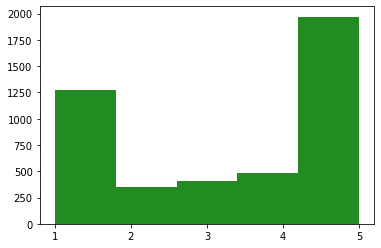

In [80]:
plt.hist(df['rating'], bins=5, color='forestgreen')
plt.xticks(np.arange(1, 6))
plt.show()

Чтобы обеспечить качество данных для последующего обучения, переведём столбец **rating** из 5-бальной шкалы в 2-бальную - "положительные" и "отрицательные" оценки. Это понадобится в последующем для модели обучения, а также поможет сравнять распределение классов целевого прзнака по количеству.

Примем за положительные оценки 5 и 4, а за отрицательные 3, 2 и 1. Для перевода столбца **rating** в 2-бальную шкалу воспользуемся функцией `where` библиотеки `numpy`, записав в неё соответствующее условие:

In [95]:
# условие:
# 5//2 = 2 > 1, 4//2 = 2 > 1
# 3//2 = 1 = 1, 2//2 = 1 = 1, 1//2 = 0 < 1
df['rating'] = np.where(df['rating'] // 2 > 1, 1, 0)
df_check['rating'] = np.where(df_check['rating'] // 2 > 1, 1, 0)
df.head()

,updated,content,app_name,rating
0,2022-03-01 15:48:24-07:00,"It’s fun, interactive, and all around educatio...",Duolingo - Language Lessons,1
1,2022-03-01 15:18:11-07:00,"Because of Duolingo, I can speak simple senten...",Duolingo - Language Lessons,1
2,2022-03-01 15:11:03-07:00,Duolingo is s great if you have a short time t...,Duolingo - Language Lessons,1
3,2022-03-01 15:02:00-07:00,This app has carried my further than any of my...,Duolingo - Language Lessons,1
4,2022-03-01 14:28:12-07:00,Update it so you don’t have to sign in so you ...,Duolingo - Language Lessons,0


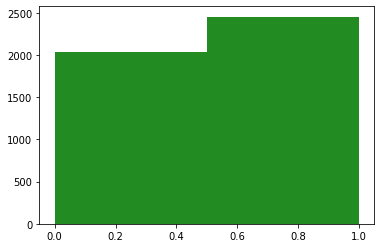

In [86]:
plt.hist(df['rating'], bins=2, color='forestgreen')
plt.show()

In [96]:
df.rating.value_counts()

1    2454
0    2030
Name: rating, dtype: int64

Удалим из таблицы лишнее количество строк с оценкой 1 (лишнее - разница между количеством оценок 1 и 0). Для этого воспользуемся функцией `choice` модуля `np.random`:

In [97]:
to_remove = np.random.choice(
    df[df['rating'] == 1].index,
    size=2454-2030,
    replace=False
)
to_remove.size

424

In [98]:
df = df.drop(to_remove)
df.rating.value_counts()[0]

2030

In [100]:
n = df_check.rating.value_counts()[1] - df_check.rating.value_counts()[0]
to_remove = np.random.choice(
    df_check[df_check['rating'] == 1].index,
    size=n,
    replace=False
)
df_check = df_check.drop(to_remove)
df_check.rating.value_counts()

0    2025
1    2025
Name: rating, dtype: int64

Сохраним полученные таблицы:

In [102]:
df.to_csv('datasets/train/final_reviews_train.csv', sep='|', index=False)
df_check.to_csv('datasets/check/final_reviews_check.csv', sep='|', index=False)

### Создание и обучение моделей

#### Использование модели сверточной нейронной сети (CNN)

Для классификации данных воспользуемся сверточной нейронной сетью, создаваемую и обучаемую с использованием конвейера spaCy.

##### Подготовка данных для модели

Для обучение сверточной нейронной сети spaCy необходимо преобразовать данные в список кортежей вида:

```
(
    'Текст отзыва',
    {'cats':
        {'pos': True/False,
         'neg': True/False}
    }
)
```

где `cats` - метка категории отзыва (`pos` - позитивный отзыв, `neg` - негативный отзыв)

Загрузим данные из сохраненного ранее датасета и создадим список с необходимыми кортежами:

In [3]:
df = pd.read_csv('datasets/train/final_reviews_train.csv', sep='|')
df.head()

,updated,content,app_name,rating
0,2022-03-01 15:48:24-07:00,"It’s fun, interactive, and all around educatio...",Duolingo - Language Lessons,1
1,2022-03-01 15:18:11-07:00,"Because of Duolingo, I can speak simple senten...",Duolingo - Language Lessons,1
2,2022-03-01 15:11:03-07:00,Duolingo is s great if you have a short time t...,Duolingo - Language Lessons,1
3,2022-03-01 15:02:00-07:00,This app has carried my further than any of my...,Duolingo - Language Lessons,1
4,2022-03-01 14:28:12-07:00,Update it so you don’t have to sign in so you ...,Duolingo - Language Lessons,0


In [9]:
custom_reviews = []
for _, row in df[['content', 'rating']].iterrows():
    spacy_label = {
        'cats': {
            'pos': row['rating'] == 1,
            'neg': row['rating'] == 0
        }
    }
    custom_reviews.append((row['content'], spacy_label))

custom_reviews[0]

('It’s fun, interactive, and all around educational while learning more than expected! I start my day with my little green owl and add a lesson or two before heading to bed!',
 {'cats': {'pos': True, 'neg': False}})

Перетасуем полученный список отзывов с метками, используя функцию `shuffle`:

In [11]:
from random import shuffle

shuffle(custom_reviews)

custom_reviews[0]

('yuh i love this app sm i probably would have failed my history and german classes so ty quizlet- stream the blessed-cursed mv by enhypen no harm in doing so…maybe even take an enhypen quiz on quizlet ‼',
 {'cats': {'pos': True, 'neg': False}})

Разобьем полученные данные на обучающую и тестовую выборки в отношении 80% к 20%:

In [15]:
split = round(len(custom_reviews) * 0.8) # получаем границу разбиения исходных данных
train_data = custom_reviews[:split]
test_data = custom_reviews[split:]

test_data[0]

('Soooooo helpful through middle and high school!',
 {'cats': {'pos': True, 'neg': False}})

##### Обучение модели

Испортируем все необходимые модули:

In [16]:
import spacy
from spacy.util import minibatch, compounding
from spacy.pipeline.textcat import Config, single_label_cnn_config
from spacy.training.example import Example

Обучение предполагается запустить несколько раз. На каждой итерации будем оценивать прогресс обучения модели с помощью матрицы ошибок и метрик Precision, Recall и F-score, используя следующую функцию:

In [20]:
def evaluate_model(tokenizer, textcat, test_data):
    reviews, labels = zip(*test_data)                    # разделим отзывы и их метки в отдельные переменные
    reviews = (tokenizer(review) for review in reviews)  # токенизируем отзывы
    
    # зададим начальные значения для значений матрицы ошибок
    # TP не 0, а малое число, чтобы в знаменателе не оказался 0
    TP, FP, TN, FN = 1e-8, 0, 0, 0 
    
    # пройдем циклом по отзывам и подсчитаем значения TP, FP, TN, FN
    for i, review in enumerate(textcat.pipe(reviews)):
        true_label = labels[i]['cats']
        score_pos = review.cats['pos'] 
        if true_label['pos']:
            if score_pos >= 0.5:
                TP += 1
            else:
                FN += 1
        else:
            if score_pos >= 0.5:
                FP += 1
            else:
                TN += 1

    # подсчитаем метрики
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f_score = 2 * precision * recall / (precision + recall)
    
    # получим результат для каждой итерации обучения модели
    return {'precision': precision, 'recall': recall, 'f-score': f_score}

Загрузим конвейер `en` и добавим ему компоненту `textcat`:

In [32]:
nlp = spacy.blank('en')                              # загрузка встроенного конвейера en
config = Config().from_str(single_label_cnn_config)  # использование конфигурации для CNN

# добавление компоненты textcat (категория текста - позитивная или негативная)
# если она отсутствует
if 'textcat' not in nlp.pipe_names:
    nlp.add_pipe('textcat', config=config, last=True)

# добавление меток текста, которые есть в данных
textcat = nlp.get_pipe('textcat')
textcat.add_label('pos')
textcat.add_label('neg')

1

Обучим модель 20 раз:

In [33]:
print('Начинаем обучение')
print('Loss\t\tPrec.\tRec.\tF-score')

optimizer = nlp.begin_training()  # вызов начальной функции оптимизатора

# генератор бесконечной последовательности входных чисел для функции minibatch
batch_sizes = compounding(4.0, 32.0, 1.001)

for _ in range(20):
    loss = {}                   # создание словаря для записи потерь на каждой итерации обучения
    random.shuffle(train_data)  # перемешивание данных обучающей выборки перед обучением
    
    # разбиение обучающей выборки на пакеты разного размера
    for batch in minibatch(train_data, size=batch_sizes):
        
        # обучение на данных пакета
        for text, labels in batch:
            doc = nlp.make_doc(text)                  # создание Doc из текста отзыва
            example = Example.from_dict(doc, labels)  # создание экземпляра из документа и метки
            
            # обучение модели
            nlp.update([example], drop=0.2, sgd=optimizer, losses=loss)
    
    # оценивание результатов обучения с использованием функции evaluate_model
    evaluation_results = evaluate_model(
        tokenizer=nlp.tokenizer,
        textcat=textcat,
        test_data=test_data
    )
    
    # вывод результатов обучения на каждой итерации
    print(f'{loss["textcat"]:9.6f}\t' +
          f'{evaluation_results["precision"]:.3f}\t' +
          f'{evaluation_results["recall"]:.3f}\t' +
          f'{evaluation_results["f-score"]:.3f}'
    )

Начинаем обучение
Loss		Prec.	Rec.	F-score
1303.946233	0.965	0.561	0.709
857.231039	0.672	0.943	0.785
663.083819	0.810	0.858	0.833
534.612201	0.872	0.764	0.815
409.523773	0.788	0.876	0.830
288.572687	0.893	0.666	0.763
240.386732	0.857	0.755	0.803
203.613020	0.873	0.753	0.808
199.596711	0.873	0.677	0.763
169.481751	0.892	0.703	0.786
145.488750	0.802	0.817	0.810
123.866145	0.794	0.803	0.799
102.399415	0.861	0.737	0.794
92.856736	0.837	0.751	0.791
107.598849	0.836	0.808	0.822
80.404068	0.839	0.789	0.814
98.049307	0.766	0.876	0.818
87.024901	0.884	0.735	0.803
69.383179	0.890	0.682	0.772
72.473635	0.880	0.721	0.792


Показатели Precision, Recall и F-score соответственно равны 0.880, 0.721 и 0.792.

Сохраним обученную модель:

In [34]:
with nlp.use_params(optimizer.averages):
    nlp.to_disk('cnn_model')

##### Предсказание на реальных данных

Загрузим текст для оценки из тестового набора данных:

In [3]:
df_check = pd.read_csv('datasets/check/final_reviews_check.csv', sep='|')
text = df_check['content'][0]
rating = df_check['rating'][0]
rating, text

(0,
 'So I was doing a lightning round and all it’s giving me is lessons I haven’t done before please help')

Загрузим созданную модель и используем её для предсказания тональности текста:

In [14]:
loaded_model = spacy.load('cnn_model')
predict_text = loaded_model(text)

score = 'Положительный отзыв' if predict_text.cats['pos'] > predict_text.cats['neg'] else 'Негативный отзыв'

print(
    f'Текст отзыва: {text}\n' +
    f'Реальная оценка: {rating} \n' +
    f'Score_pos: {predict_text.cats["pos"]:.3f} | ' +
    f'Score_neg: {predict_text.cats["neg"]:.3f} | ' +
    f'Предсказание: {prediction}'
)

Текст отзыва: So I was doing a lightning round and all it’s giving me is lessons I haven’t done before please help
Реальная оценка: 0 
Score_pos: 0.003 | Score_neg: 0.997 | Предсказание: Негативный отзыв


## Выводы

Выводы

## Использованные источники

1. [«Люблю» и «ненавижу»: анализ эмоциональной окраски текста с помощью Python](https://proglib.io/p/lyublyu-i-nenavizhu-analiz-emocionalnoy-okraski-teksta-s-pomoshchyu-python-2020-11-13)